# Field Failure Data Analysis

## Introduction

In [8]:
# Import relevant modules
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# %matplotlib notebook
# from IPython.core.interactiveshell import InteractiveShell

In [10]:
# Utility functions
def sensitivity_analysis(dataframe, c_wins, filepath):
    if(not os.path.isfile(filepath)):
        print('Creating file, this may take a while...\n')
        tuples = []

        for win in c_wins:
            tup = 1
            prev = int(dataframe.loc[0,'Timestamp'])

            for index in range(dataframe.shape[0]-1):
                succ = int(dataframe.loc[index+1,'Timestamp'])
                if  succ - prev >= win:
                    tup = tup + 1
                prev = succ

#             print(str(win)+" "+str(tup))    
            tuples.append(tup)
        
        sens_file = open(filepath, 'w')
        
        for i in range(len(c_wins)):
            sens_file.write(str(c_wins[i]) + ' ' + str(tuples[i]) + '\n')
        
        sens_file.close()
    else:
        print('File already exists!\n')

## Mercury

In [31]:
# Load Mercury Data
df_mercury = pd.read_csv('Dataset/MercuryErrorLog.txt', names = ['Timestamp', 'Node', 'Subsystem', "Message"])

df_mercury.loc[:,'Node'] = df_mercury.loc[:,'Timestamp'].str.split(' ', n=3).str[1]
df_mercury.loc[:,'Subsystem'] = df_mercury.loc[:,'Timestamp'].str.split(' ', n=3).str[2]
df_mercury.loc[:,'Message'] = df_mercury.loc[:,'Timestamp'].str.split(' ', n=3).str[3]
df_mercury.loc[:,'Timestamp'] = df_mercury.loc[:,'Timestamp'].str.split(' ', n=3).str[0]

print('Log file has ' + str(df_bgl.shape[0]) + ' entries and ' + str(df_bgl.shape[1]) + ' columns.')
df_mercury.head()

Log file has 125624 entries and 4 columns.


,Timestamp,Node,Subsystem,Message
0,1167637660,tg-c645,PRO,+BEGIN HARDWARE ERROR STATE AT CMC
1,1167637660,tg-c645,PRO,Device Error Info Section
2,1167637660,tg-c645,PRO,Error Map: x
3,1167637720,tg-c645,PRO,+BEGIN HARDWARE ERROR STATE AT CMC
4,1167637720,tg-c645,PRO,Device Error Info Section


### Data Manipulation

#### Sensitivity analysis

File already exists!



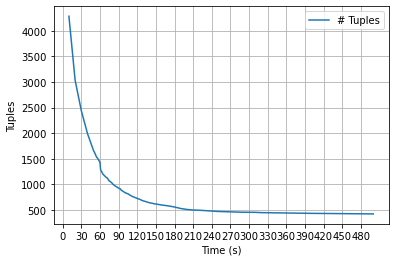

In [6]:
c_wins = np.arange(10,510,10)
accuracy = np.arange(50,150,1)
c_wins = c_wins.tolist()
c_wins.extend(accuracy)
c_wins.sort()

filepath = 'Dataset/MercurySensitivity.txt'
sensitivity_analysis(df_mercury, c_wins, filepath)

df_mercury_sensitivity = pd.read_csv(filepath, sep = " ", names = ["Time (s)", "# Tuples"])

plt.plot(df_mercury_sensitivity["Time (s)"],df_mercury_sensitivity["# Tuples"], label = "# Tuples")
plt.xticks(np.arange(0, 500, step = 30))
plt.xlabel("Time (s)")
plt.ylabel("Tuples")
plt.legend()
plt.grid()

## Blue Gene/L

In [30]:
# Load Blue Gene Data
df_bgl = pd.read_csv('Dataset/BGLErrorLog.txt', names = ['Timestamp', 'Node', 'Card', "Message"])

df_bgl.loc[:,'Node'] = df_bgl.loc[:,'Timestamp'].str.split(' ', n=3).str[1]
df_bgl.loc[:,'Card'] = df_bgl.loc[:,'Timestamp'].str.split(' ', n=3).str[2]
df_bgl.loc[:,'Message'] = df_bgl.loc[:,'Timestamp'].str.split(' ', n=3).str[3]
df_bgl.loc[:,'Timestamp'] = df_bgl.loc[:,'Timestamp'].str.split(' ', n=3).str[0]

print('Log file has ' + str(df_bgl.shape[0]) + ' entries and ' + str(df_bgl.shape[1]) + ' columns.')
df_bgl.head()

Log file has 125624 entries and 4 columns.


,Timestamp,Node,Card,Message
0,1128621350,R00-M0-N0,J18-U01,Lustre mount FAILED : bglio2 : block_id : loc...
1,1128621350,R01-M1-N0,J18-U11,Lustre mount FAILED : bglio21 : block_id : lo...
2,1128621351,R07-M0-NC,J18-U01,Lustre mount FAILED : bglio124 : block_id : l...
3,1128621351,R00-M0-N4,J18-U01,Lustre mount FAILED : bglio4 : block_id : loc...
4,1128621351,R02-M0-N4,J18-U01,Lustre mount FAILED : bglio36 : block_id : lo...


### Data Manipulation

#### Sensitivity analysis

File already exists!



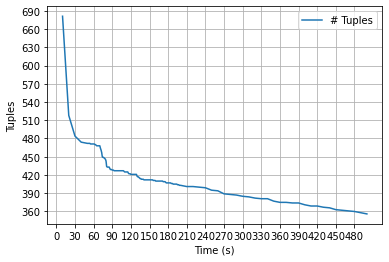

In [12]:
c_wins = np.arange(10,510,10)
accuracy = np.arange(50,200,1)
c_wins = c_wins.tolist()
c_wins.extend(accuracy)
c_wins.sort()

filepath = 'Dataset/BGLSensitivity.txt'
sensitivity_analysis(df_bgl, c_wins, filepath)

df_bgl_sensitivity = pd.read_csv(filepath, sep = " ", names = ["Time (s)", "# Tuples"])

plt.plot(df_bgl_sensitivity["Time (s)"],df_bgl_sensitivity["# Tuples"], label = "# Tuples")
plt.xticks(np.arange(0, 500, step = 30))
plt.yticks(np.arange(360, 700, step = 30))
plt.xlabel("Time (s)")
plt.ylabel("Tuples")
plt.grid()
plt.legend()

### Temporal coalescence

In [7]:
# # Versione Pecchia
# logfile = 'Dataset/BGLErrorLog.txt'
# for cwin in c_wins:

#     logfiled = open(logfile,"r")
#     loglines = logfiled.readlines()

#     tcount=1

#     i=0
#     line = loglines[i].split()
#     prev = line[0]

#     i = i + 1
#     while i < len(loglines):
#         line = loglines[i].split()
#         succ = line[0]


#         #calcolo delta
#         delta = int(succ) - int(prev)

#         #print str(delta) +" " +str(cwin)

#         if int(delta)<int(cwin):
#             j=0
#         else:
#             tcount = int(tcount) + 1

#         prev = succ
#         i = i + 1

#     print(str(cwin)+" "+str(tcount))
    

In [8]:
# # Versione Base nostra
# c_wins = np.arange(10,510,10)
#     tuples = []

#     for win in c_wins:
#         tup = 1
#         prev = int(df_mercury.loc[0,'Timestamp'])

#         for index in range(df_mercury.shape[0]-1):
#             succ = int(df_mercury.loc[index+1,'Timestamp'])
#             if  succ - prev >= win:
#                 tup = tup + 1
#             prev = succ

#         print(str(win)+" "+str(tup))    

#         tuples.append(tup)